In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
# Load and preprocess the dataset
data = pd.read_csv("c:/Users/nazil/Downloads/data_set_hackathon.csv")
data['order_date'] = pd.to_datetime(data['order_date'])
data['requested_delivery_date'] = pd.to_datetime(data['requested_delivery_date'])
data['Year-Month'] = data['order_date'].dt.to_period('M')

C:\Users\nazil\AppData\Local\Temp\ipykernel_3312\2670884699.py:3: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['order_date'] = pd.to_datetime(data['order_date'])
C:\Users\nazil\AppData\Local\Temp\ipykernel_3312\2670884699.py:4: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['requested_delivery_date'] = pd.to_datetime(data['requested_delivery_date'])


In [3]:
# Group Data by Monthly Orders
monthly_orders = data.groupby('Year-Month')['Customer Order Code'].nunique()

# Split Data into Train/Test
train = monthly_orders[:int(len(monthly_orders)*0.8)]
test = monthly_orders[int(len(monthly_orders)*0.8):]

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2420 non-null   datetime64[ns]
 1   requested_delivery_date  2420 non-null   datetime64[ns]
 2   Customer Country Code    2420 non-null   object        
 3   Product Code             2420 non-null   object        
 4   Description              2420 non-null   object        
 5   order_type               2420 non-null   object        
 6   Customer Order Code      2420 non-null   int64         
 7   value                    2420 non-null   float64       
 8   Curr                     2420 non-null   object        
 9   items                    2420 non-null   object        
 10  Route                    2420 non-null   object        
 11  Year-Month               2420 non-null   period[M]     
dtypes: datetime64[ns](2), float64(1), 

Time Series Analysis and SARIMA Model

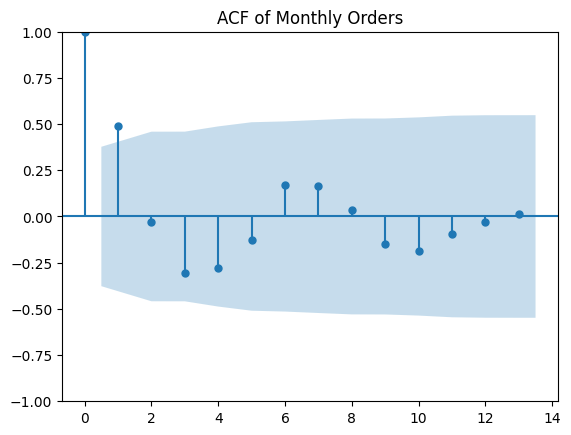

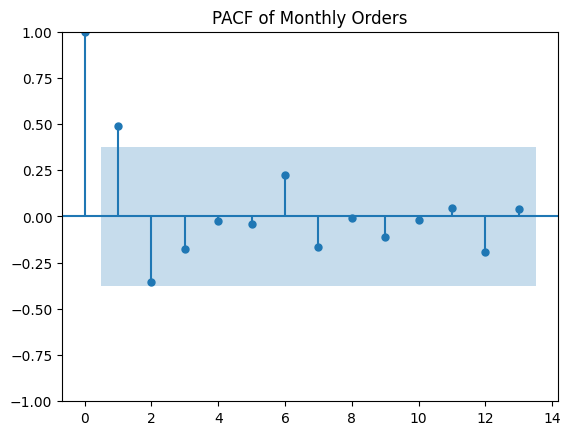

In [5]:
# Determine the maximum allowed lags
max_lags = len(monthly_orders) // 2

# ACF Plot
plot_acf(monthly_orders, lags=max_lags)
plt.title("ACF of Monthly Orders")
plt.show()

# PACF Plot
plot_pacf(monthly_orders, lags=max_lags)
plt.title("PACF of Monthly Orders")
plt.show()

In [6]:
# SARIMA Model Fitting
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum

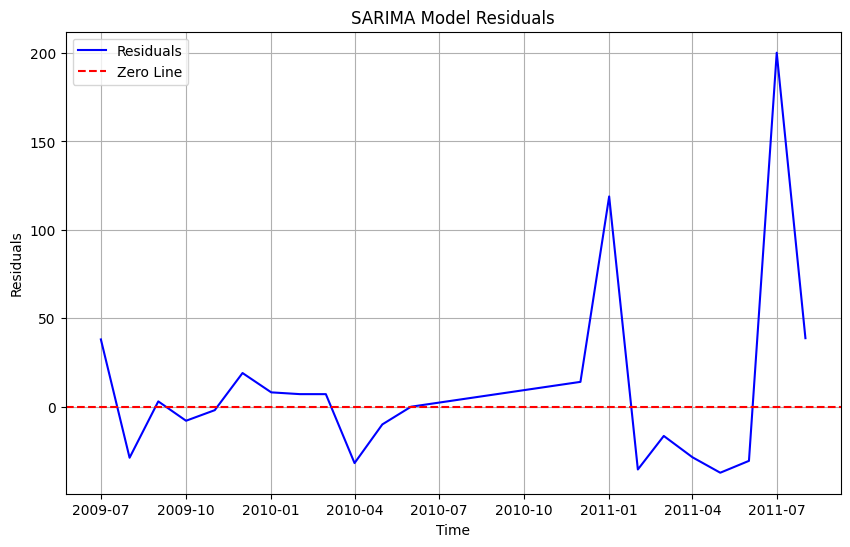

In [7]:
# Residual Diagnostics
residuals = model_fit.resid

# Convert PeriodIndex to DatetimeIndex for plotting
residuals.index = residuals.index.to_timestamp()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='blue')
plt.axhline(0, linestyle='--', color='red', label='Zero Line')
plt.title("SARIMA Model Residuals")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Statistical Test for White Noise
ljung_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test Results:\n", ljung_test)

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  9.920493   0.447496


In [9]:
# Forecast and Evaluation
forecast = model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [10]:
# MAPE Calculation for SARIMA
mape = mean_absolute_percentage_error(test.values, forecast_values)
print(f"SARIMA MAPE: {mape:.2%}")

SARIMA MAPE: 6858.90%


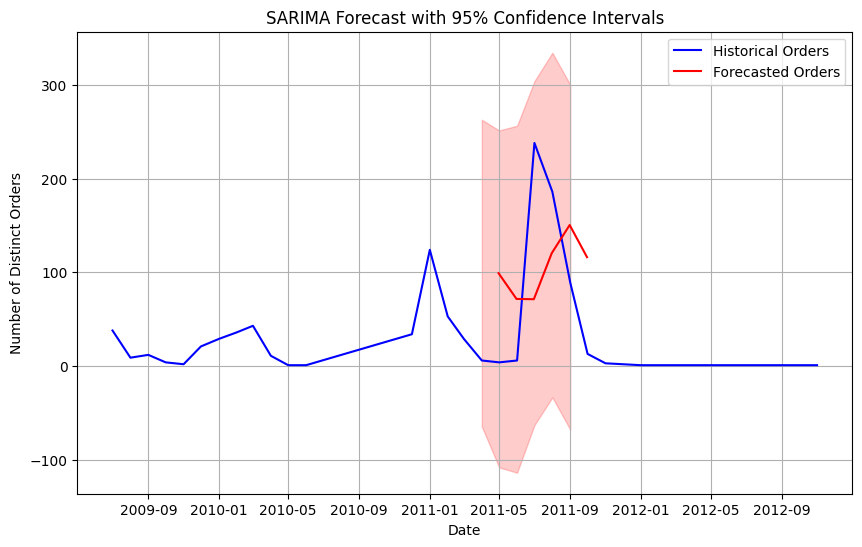

In [11]:
# Convert PeriodIndex to DatetimeIndex for plotting
monthly_orders.index = monthly_orders.index.to_timestamp()
forecast_ci.index = forecast_ci.index.to_timestamp()

# Plot Forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders.index, monthly_orders, label='Historical Orders', color='blue')
plt.plot(forecast_values.index, forecast_values, label='Forecasted Orders', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title("SARIMA Forecast with 95% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Number of Distinct Orders")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Print forecast values and confidence intervals
print("Forecasted Values:")
print(forecast.predicted_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

Forecasted Values:
2011-04     99.112331
2011-05     71.640631
2011-06     71.349741
2011-07    120.487023
2011-08    150.451042
2011-09    116.187983
Freq: M, Name: predicted_mean, dtype: float64

Confidence Intervals:
            lower Customer Order Code  upper Customer Order Code
2011-04-01                 -64.493996                 262.718657
2011-05-01                -107.985039                 251.266302
2011-06-01                -113.681597                 256.381078
2011-07-01                 -62.876676                 303.850723
2011-08-01                 -33.300988                 334.203072
2011-09-01                 -67.702842                 300.078809


Classification Model for Product Choice

Empirical Quantiles for Demand and Lead Time

In [ ]:
from scipy.stats.mstats import mquantiles

# Empirical Quantiles for Quantity
quantile_25, quantile_50, quantile_75 = mquantiles(data['items'].astype(float), prob=[0.25, 0.5, 0.75])
print(f"Demand Quantiles - 25%: {quantile_25}, 50%: {quantile_50}, 75%: {quantile_75}")

# Empirical Quantiles for Lead Time
lead_time = (data['requested_delivery_date'] - data['order_date']).dt.days
lead_time_quantiles = mquantiles(lead_time, prob=[0.25, 0.5, 0.75])
print(f"Lead Time Quantiles - 25%: {lead_time_quantiles[0]}, 50%: {lead_time_quantiles[1]}, 75%: {lead_time_quantiles[2]}")


Monte Carlo Simulation for Total Demand

In [ ]:
n_simulations = 1000
simulated_total_demand_5_month = []

for _ in range(n_simulations):
    simulated_monthly_orders = np.random.poisson(train.mean())
    simulated_quantity = np.random.choice([quantile_25, quantile_50, quantile_75])
    simulated_lead_time = np.random.choice(lead_time_quantiles)
    
    total_demand = simulated_monthly_orders * simulated_quantity * simulated_lead_time
    simulated_total_demand_5_month.append(total_demand)

# Analyze Simulation Results
simulated_total_demand_5_month = np.array(simulated_total_demand_5_month)
mean_demand = simulated_total_demand_5_month.mean()
ci_5_month = np.percentile(simulated_total_demand_5_month, [2.5, 97.5])

print(f"Simulated 5-Month Demand: Mean={mean_demand}, 95% CI={ci_5_month}")
